In [1]:
from pathlib import Path
import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
sns.set_theme(context='paper',font_scale=1.2,style='whitegrid')
figsize = (5,5)

In [2]:
box_drive_results_path = Path('/Users/dcutting/Library/CloudStorage/Box-Box/Exscientia - Bonvin Lab share/results/')


In [3]:
local_results_path = Path('../data/results')
local_results_path.mkdir(exist_ok=True)


# Unzip from box folder, this takes up a lot of space on harddrive!

In [4]:
# for filepath in (box_drive_results_path / "haddock_runs").iterdir():
#     if tarfile.is_tarfile(filepath):
#         with tarfile.open(filepath, mode='r:gz') as file:
#             file.extractall(local_results_path)


# Read RMSD notebook, drop some data

In [5]:
rmsds_df = pd.read_csv('../data/para_epi_interface_rmsds.csv')
rmsds_df = rmsds_df.loc[(rmsds_df['pdb'] != '7kpj') & (rmsds_df['pdb'] !='7kn4')]
rmsds_df.loc[rmsds_df['model'] == 'AF2', 'model'] = 'AlphaFold2'


In [6]:
print(sorted(rmsds_df['pdb'].unique()))

['6xsw', '7bbj', '7bnv', '7cj2', '7daa', '7dk2', '7e3o', '7e5o', '7e72', '7e9b', '7f7e', '7k7h', '7k9j', '7kez', '7kf0', '7kf1', '7kn3', '7kql', '7kyo', '7l7r', '7lf7', '7lfa', '7lfb', '7lr3', '7lr4', '7m3n', '7mdj', '7mrz', '7msq', '7mzf', '7mzg', '7mzh', '7mzi', '7mzj', '7mzk', '7n0u', '7n3c', '7n3d', '7n3i', '7n4i', '7n4j', '7np1', '7nx3', '7o52', '7or9', '7phu', '7phw', '7pi7', '7pqy', '7pr0', '7ps0', '7ps1', '7ps2', '7ps4', '7ps6', '7q0g', '7q0i', '7qnw', '7qny', '7qu1', '7qu2', '7r89', '7r8l', '7rah', '7rco', '7rfb', '7rks', '7s0b', '7s11', '7s13', '7s4s', '7seg', '7sem', '7shu', '7shz', '7si0', '7so9', '7stz', '7vux']


# Code for getting top dockq, protocols and stages to run

In [7]:
def get_top_dockq(filepath: Path, n_ranks: int = 1):
    df = pd.read_csv(filepath, sep='\t')
    top_dockq = df[df['caprieval_rank'].isin(range(1,n_ranks+1))]['dockq'].max()
    return top_dockq

model_name_run_dict = {'ABodyBuilder2':'ab','AlphaFold2':'af2','ABlooper':'abl','IgFold':'ig'}
protocols_dict = {'CDR-VagueEpi-AA':'CDR-EpiVag-AA-mpi-50-50', 'Para-Epi': 'Para-Epi-mpi-50-50'}
stage_to_eval_dict = {'Rigid-body' : '2_caprieval', 'Refinement' : '5_caprieval', 'Clustering': '7_caprieval'}

root_plot_folder = Path('../figures/paratope_epitope_rmsd_dockq/')
root_plot_folder.mkdir(exist_ok=True)


# Plot interface rmsd vs dockq scores


In [8]:
plot_folder = root_plot_folder / "interface_rmsd_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, (model_name, model_run_str) in enumerate(model_name_run_dict.items()):
            model_df = rmsds_df.query('model==@model_name').copy()

            model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=1) for pdb in model_df['pdb']]
            model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=10) for pdb in model_df['pdb']]

            dockq1_pearson , _ = pearsonr(model_df['rmsd_interface'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['rmsd_interface'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['rmsd_interface'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['rmsd_interface'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['rmsd_interface'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['rmsd_interface'], model_df['dockq_10'])



            sns.scatterplot(x="rmsd_interface", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="rmsd_interface", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'min i-RMSD $\left(\AA\right)$')
        ax_dockq1.set_ylabel(f'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_interface_rmsd_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'min i-RMSD $\left(\AA\right)$')
        ax_dockq10.set_ylabel(f'{stage} DockQ-T10')

        #ax_dockq10.set_xlim([0,5])
        ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_interface_rmsd_all_models_{protocol}_{stage}.png',dpi=200)


# Paratope rmsd

In [9]:
plot_folder = root_plot_folder / "paratope_rmsd_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, (model_name, model_run_str) in enumerate(model_name_run_dict.items()):
            model_df = rmsds_df.query('model==@model_name').copy()

            model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=1) for pdb in model_df['pdb']]
            model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=10) for pdb in model_df['pdb']]

            dockq1_pearson , _ = pearsonr(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['rmsd_paratope'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['rmsd_paratope'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['rmsd_paratope'], model_df['dockq_10'])



            sns.scatterplot(x="rmsd_paratope", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="rmsd_paratope", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'Paratope RMSD $\left(\AA\right)$')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')
        #ax_dockq1.set_xlim([0,5])
        ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_rmsd_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(fr'Paratope RMSD $\left(\AA\right)$')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_rmsd_all_models_{protocol}_{stage}.png',dpi=200)


# Epitope rmsds

In [10]:
plot_folder = root_plot_folder / "epitope_rmsd_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, (model_name, model_run_str) in enumerate(model_name_run_dict.items()):
            model_df = rmsds_df.query('model==@model_name').copy()

            model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=1) for pdb in model_df['pdb']]
            model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=10) for pdb in model_df['pdb']]

            dockq1_pearson , _ = pearsonr(model_df['rmsd_epitope'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['rmsd_epitope'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['rmsd_epitope'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['rmsd_epitope'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['rmsd_epitope'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['rmsd_epitope'], model_df['dockq_10'])



            sns.scatterplot(x="rmsd_epitope", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="rmsd_epitope", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'Epitope RMSD $\left(\AA\right)$')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_epitope_rmsd_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'Epitope RMSD $\left(\AA\right)$')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_epitope_rmsd_all_models_{protocol}_{stage}.png',dpi=200)


# Plot af2 dockq vs af2 paratope plddt

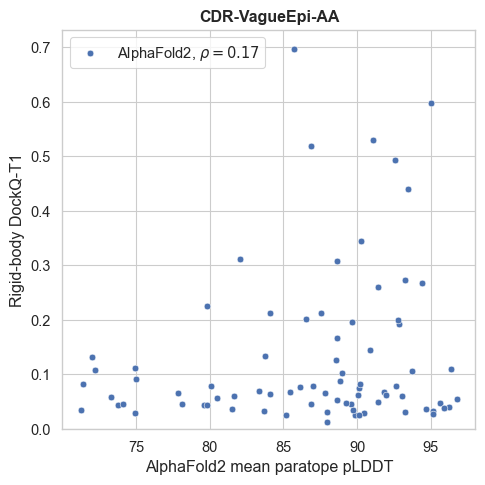

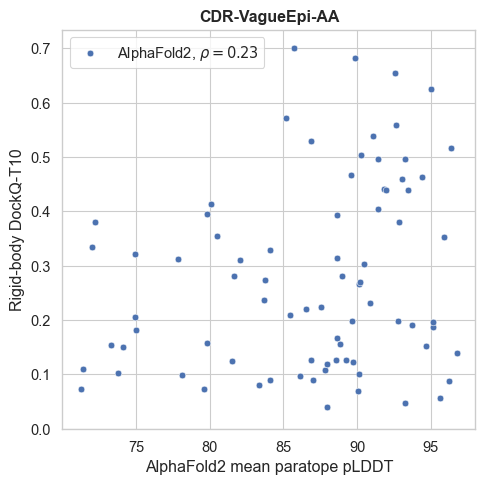

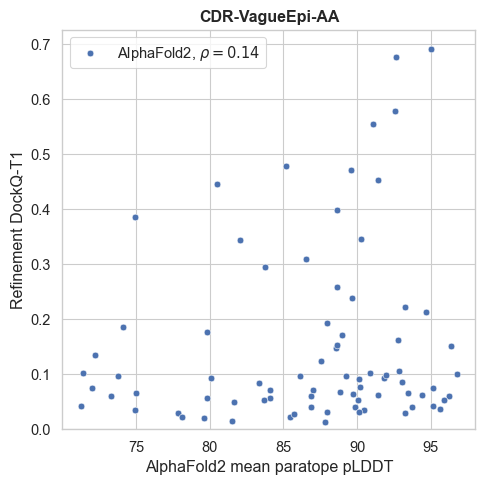

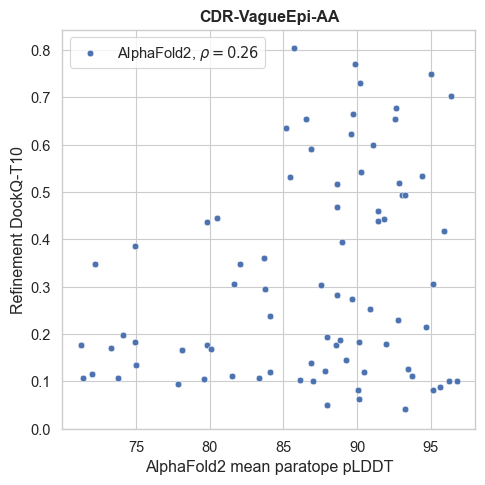

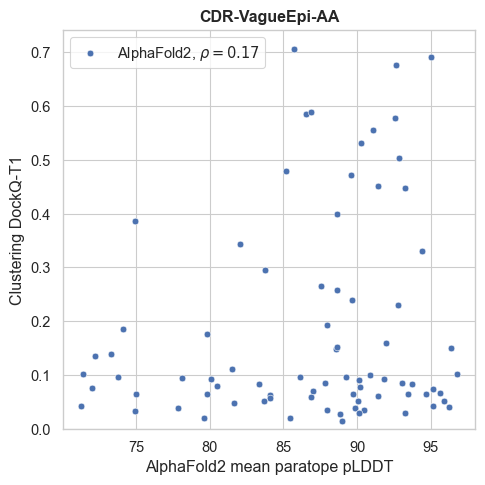

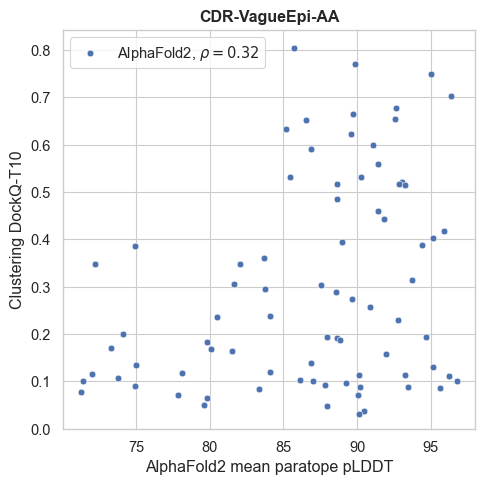

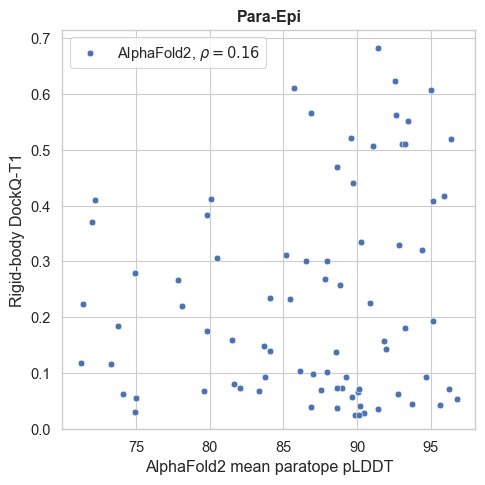

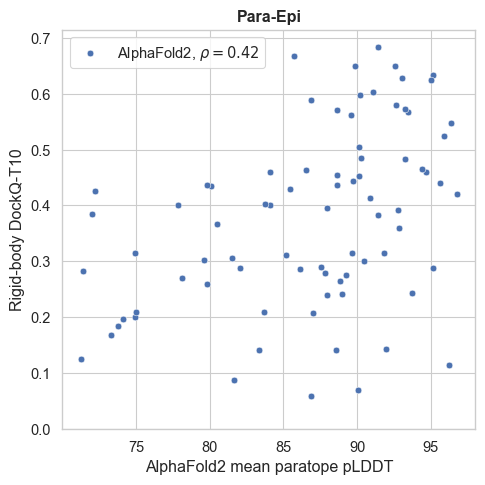

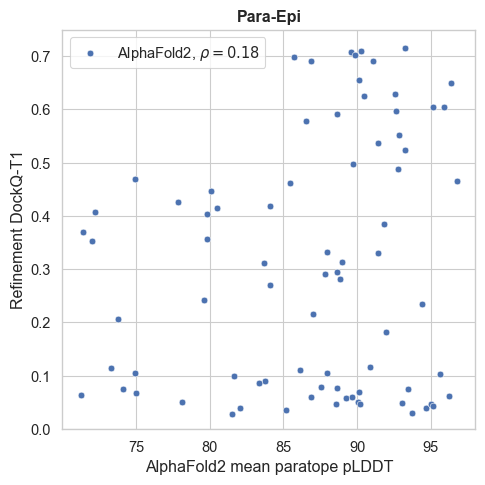

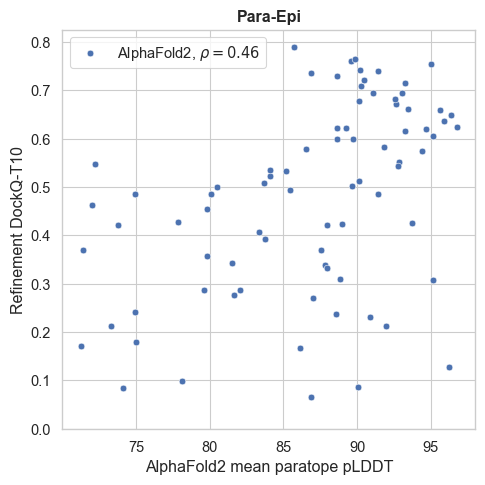

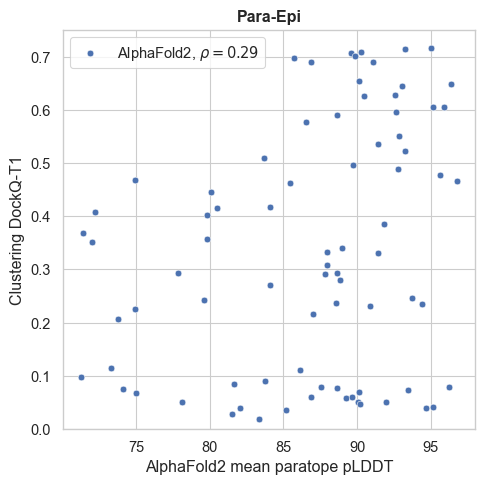

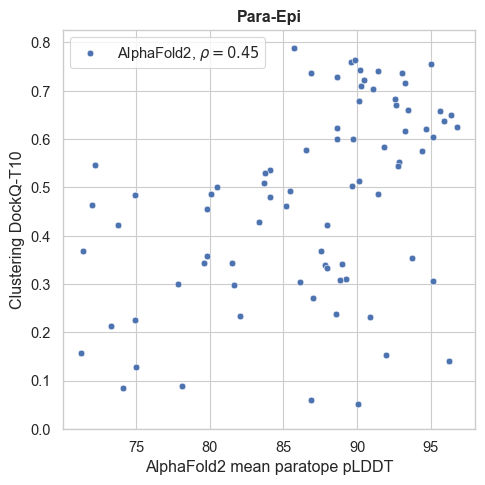

In [11]:
paratope_plddt_df = pd.read_csv('../data/AF2_antibody_rmsd_plddt_multi_regions.csv')
paratope_plddt_dict = {row.pdb : row.plddt_ave_para_epi for row in paratope_plddt_df.itertuples()}
model_name, model_run_str = 'AlphaFold2', 'af2'

plot_folder = root_plot_folder / "paratope_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        model_df['para_ave_plddt'] = [paratope_plddt_dict[pdbid] for pdbid in model_df['pdb']]
        model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=1) for pdb in model_df['pdb']]
        model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=10) for pdb in model_df['pdb']]

        dockq1_pearson , _ = pearsonr(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['para_ave_plddt'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['para_ave_plddt'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['para_ave_plddt'], model_df['dockq_10'])



        sns.scatterplot(x="para_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="para_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean paratope pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_plddt_af2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean paratope pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_plddt_af2_{protocol}_{stage}.png',dpi=200)


# Same but with vague definition of paratope


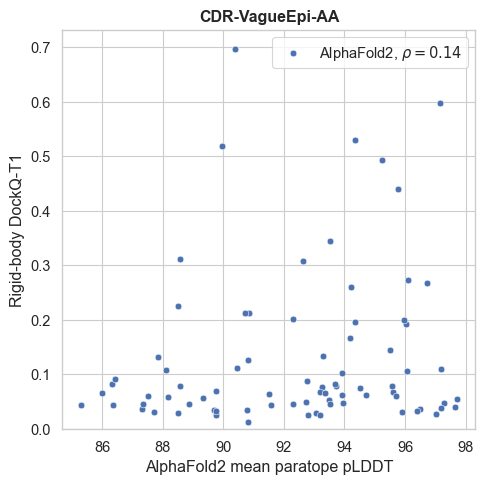

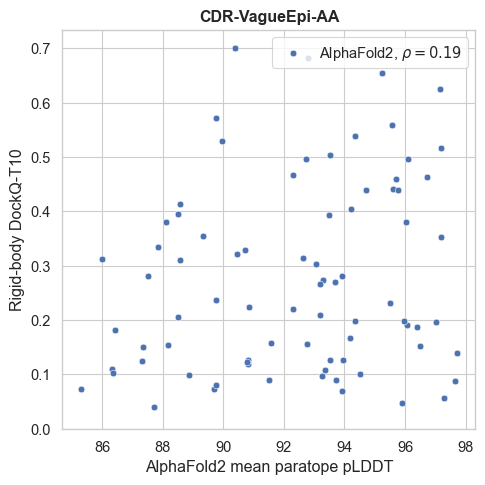

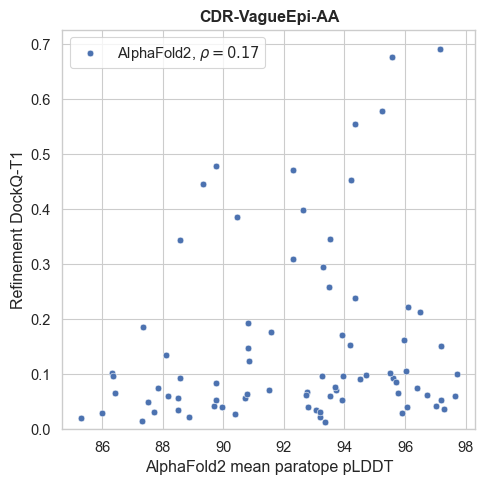

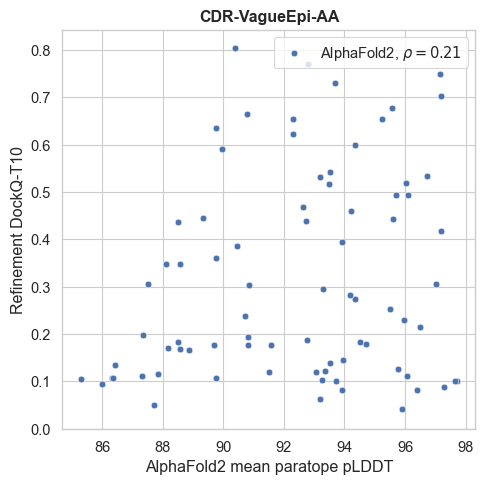

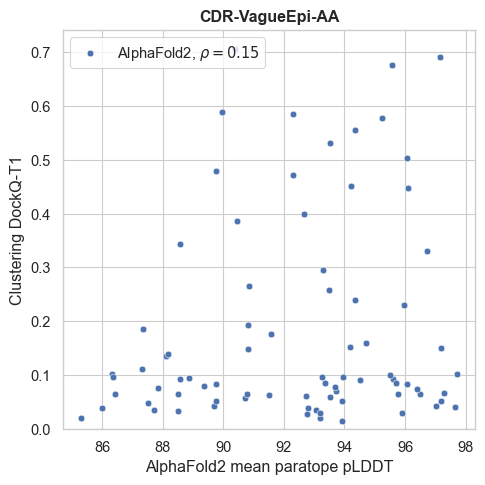

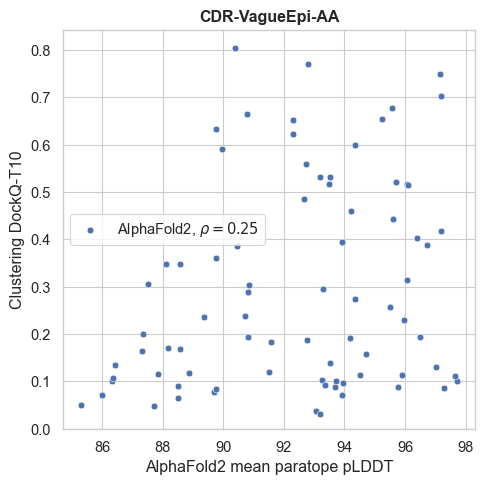

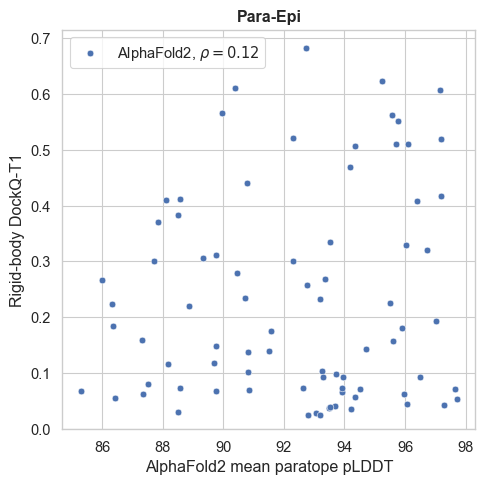

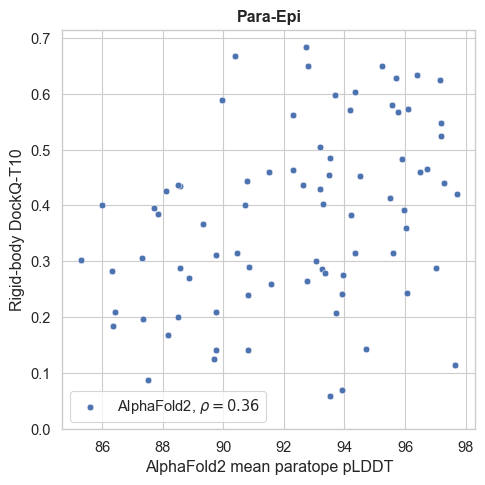

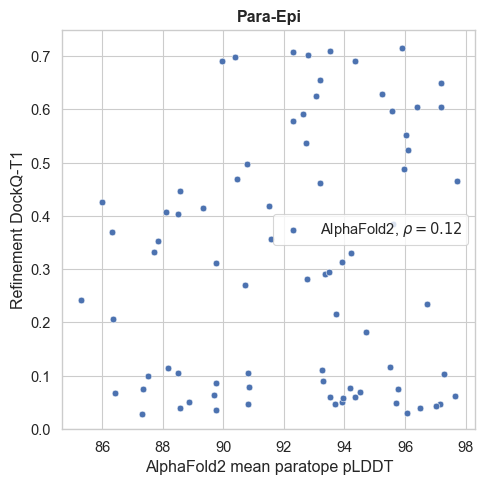

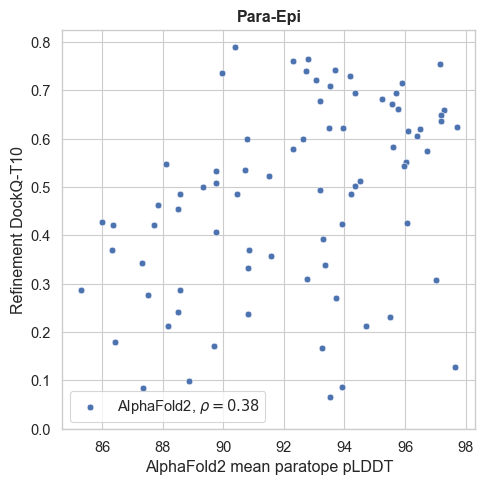

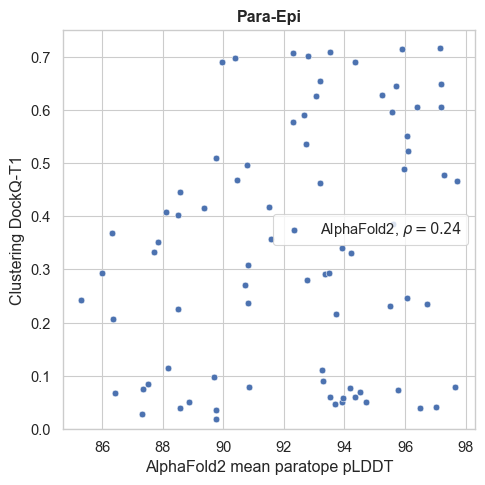

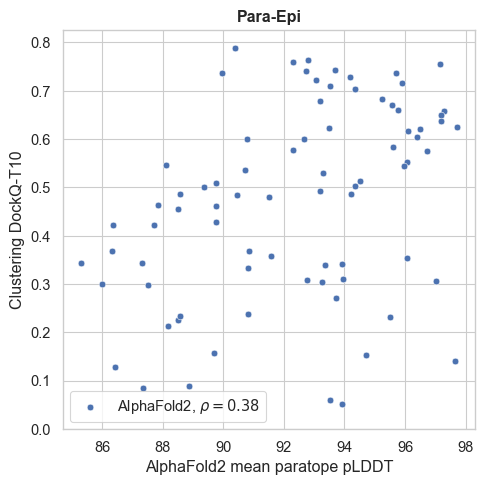

In [12]:
paratope_plddt_df = pd.read_csv('../data/AF2_antibody_rmsd_plddt_multi_regions.csv')
paratope_plddt_dict = {row.pdb : row.plddt_ave_vague for row in paratope_plddt_df.itertuples()}
model_name, model_run_str = 'AlphaFold2', 'af2'

plot_folder = root_plot_folder / "paratope_vague_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        model_df['para_ave_plddt'] = [paratope_plddt_dict[pdbid] for pdbid in model_df['pdb']]
        model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=1) for pdb in model_df['pdb']]
        model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=10) for pdb in model_df['pdb']]

        dockq1_pearson , _ = pearsonr(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['para_ave_plddt'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['para_ave_plddt'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['para_ave_plddt'], model_df['dockq_10'])



        sns.scatterplot(x="para_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="para_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean paratope pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_plddt_af2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean paratope pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_plddt_af2_{protocol}_{stage}.png',dpi=200)


# Plot AF2 dockq vs AF2 interface pLDDT

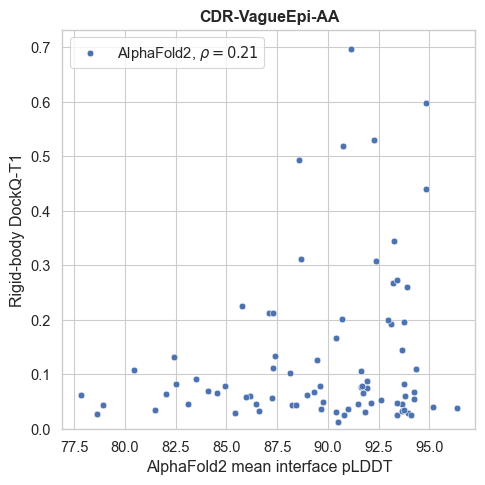

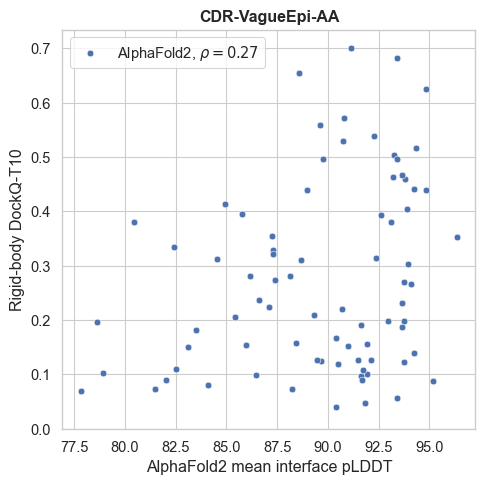

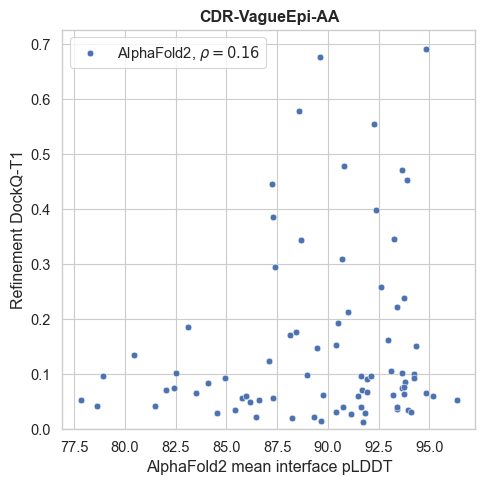

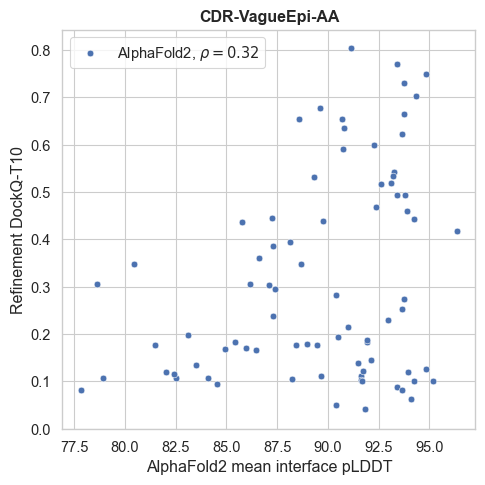

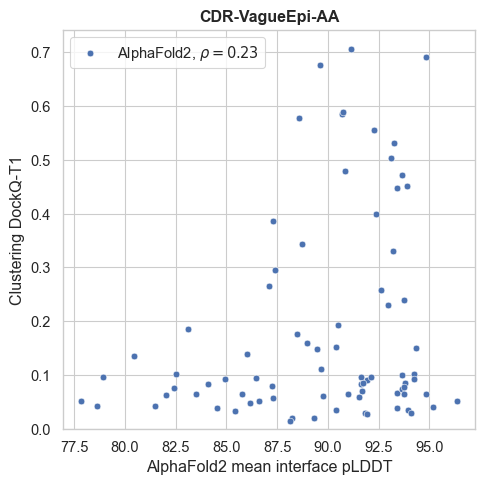

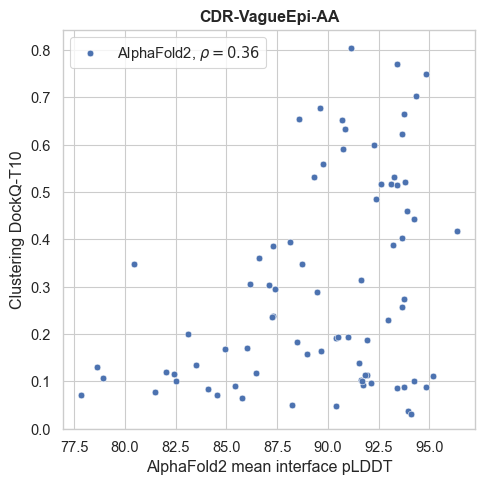

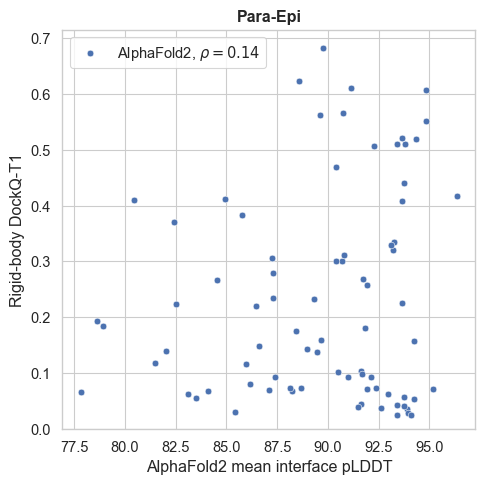

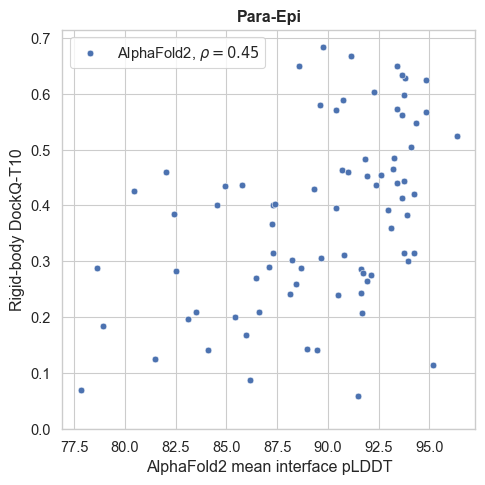

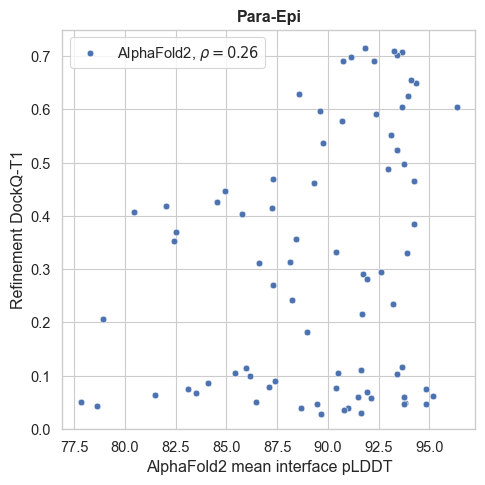

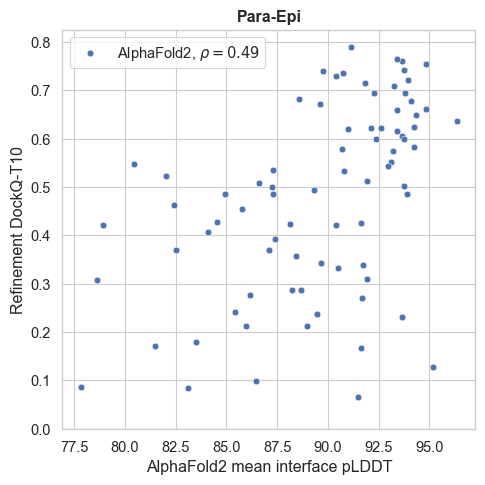

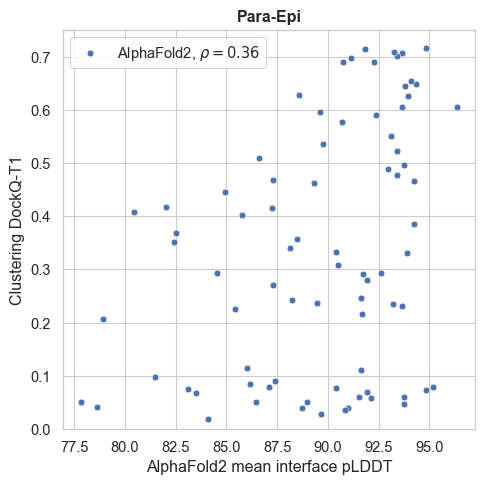

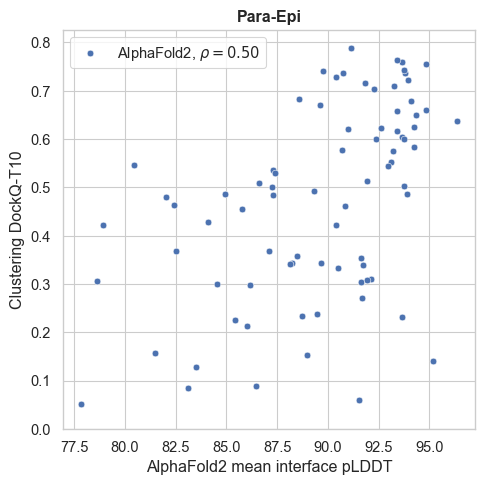

In [13]:
interface_plddt_df = pd.read_csv('../data/AF2_interface_plddt.csv')
interface_plddt_dict = {row.pdb : row.interface_ave_plddt for row in interface_plddt_df.itertuples()}
model_name, model_run_str = 'AlphaFold2', 'af2'

plot_folder = root_plot_folder / "interface_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        model_df['interface_ave_plddt'] = [interface_plddt_dict[pdbid] for pdbid in model_df['pdb']]
        model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=1) for pdb in model_df['pdb']]
        model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=10) for pdb in model_df['pdb']]

        dockq1_pearson , _ = pearsonr(model_df['interface_ave_plddt'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['interface_ave_plddt'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['interface_ave_plddt'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['interface_ave_plddt'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['interface_ave_plddt'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['interface_ave_plddt'], model_df['dockq_10'])



        sns.scatterplot(x="interface_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="interface_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean interface pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_interface_plddt_af2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean interface pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_interface_plddt_af2_{protocol}_{stage}.png',dpi=200)


# Plot ABB2 dockq vs ABB2 paratope confidence


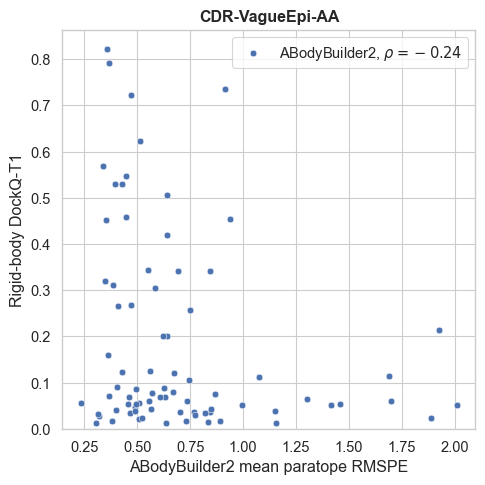

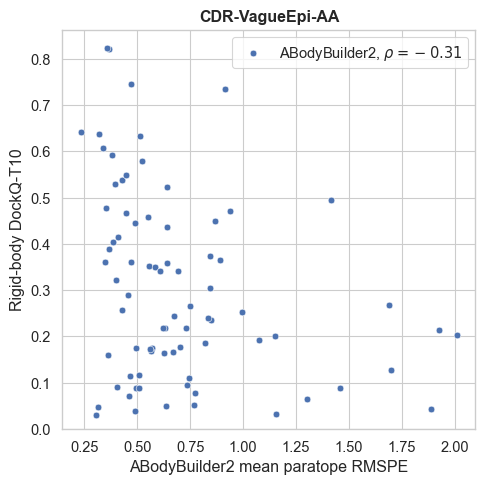

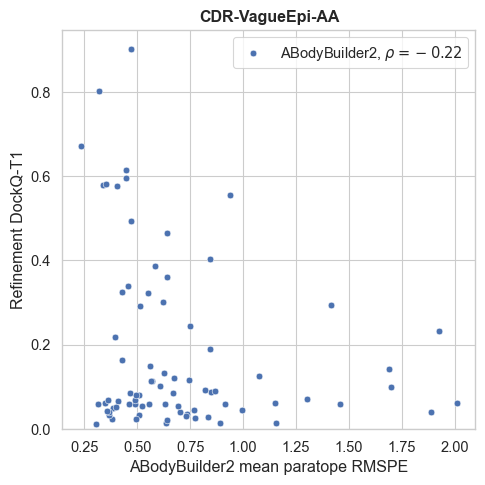

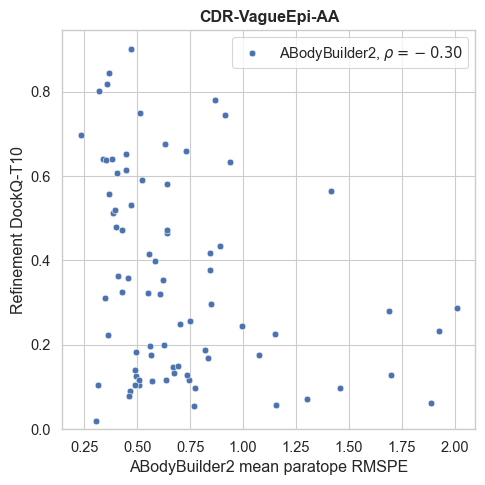

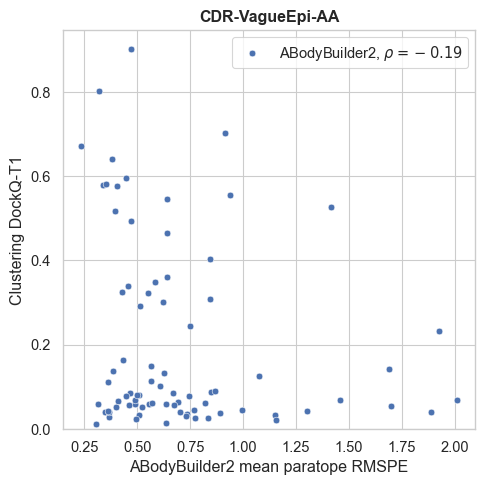

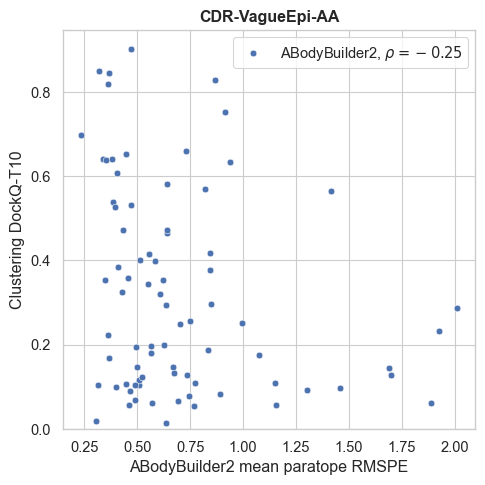

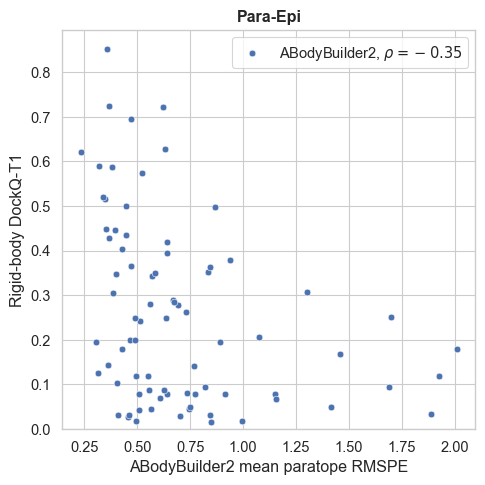

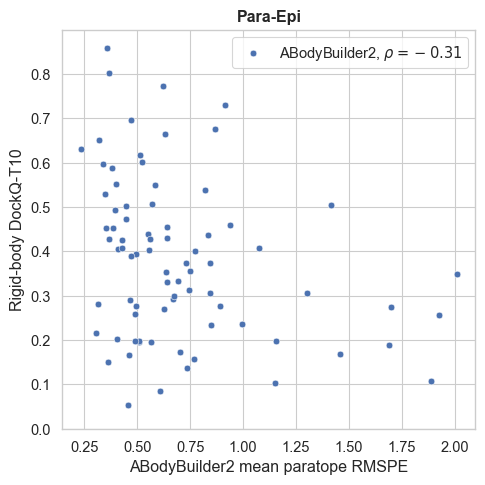

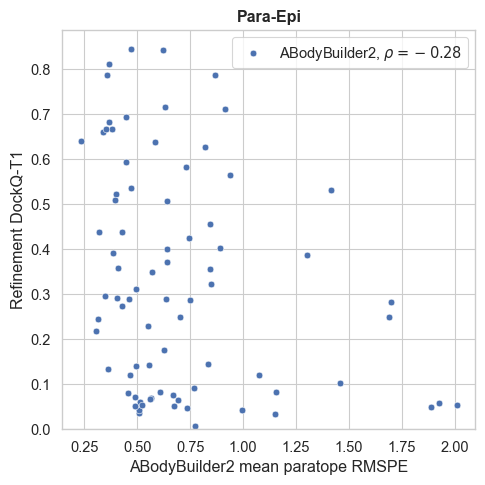

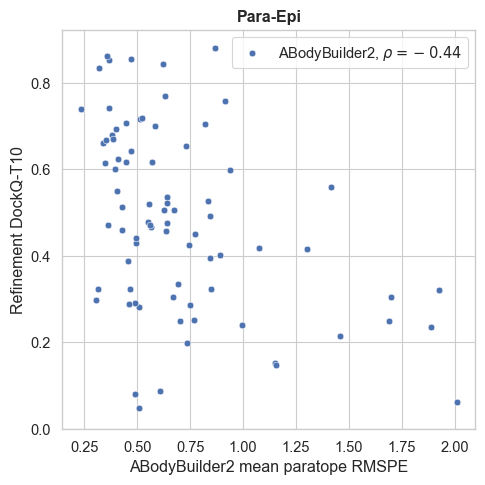

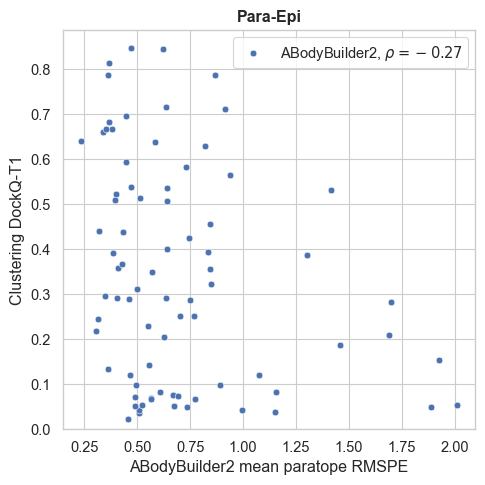

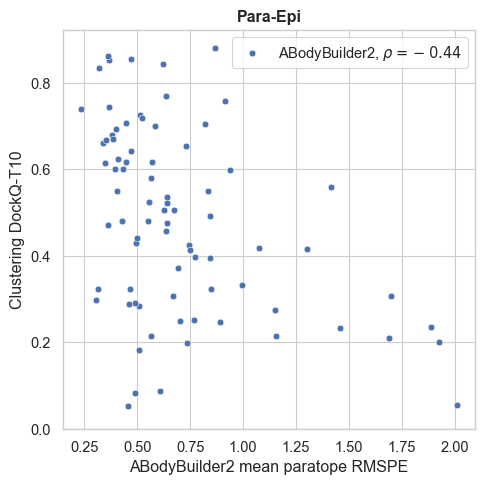

In [14]:
paratope_conf_df = pd.read_csv('../data/ABB2_antibody_rmsd_conf.csv')
paratope_conf_dict = {row.pdb : row.para_ave_conf for row in paratope_conf_df.itertuples()}
model_name, model_run_str = 'ABodyBuilder2', 'ab'

plot_folder = root_plot_folder / "paratope_conf_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)
for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        model_df['para_ave_conf'] = [paratope_conf_dict[pdbid] for pdbid in model_df['pdb']]
        model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=1) for pdb in model_df['pdb']]
        model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=10) for pdb in model_df['pdb']]

        dockq1_pearson , _ = pearsonr(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['para_ave_conf'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['para_ave_conf'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['para_ave_conf'], model_df['dockq_10'])



        sns.scatterplot(x="para_ave_conf", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="para_ave_conf", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'ABodyBuilder2 mean paratope RMSPE')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_conf_ABB2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'ABodyBuilder2 mean paratope RMSPE')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_conf_ABB2_{protocol}_{stage}.png',dpi=200)


# Same but with vague (all cdrs) definition of paratope

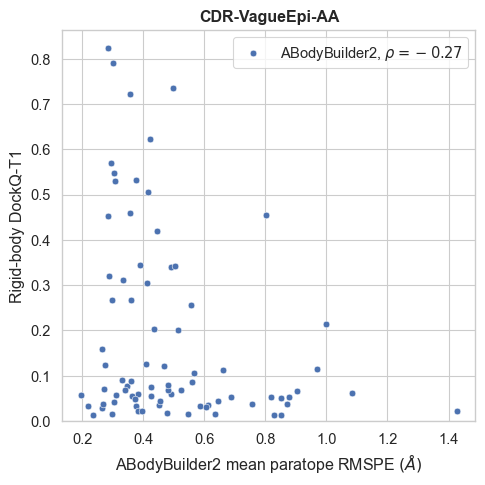

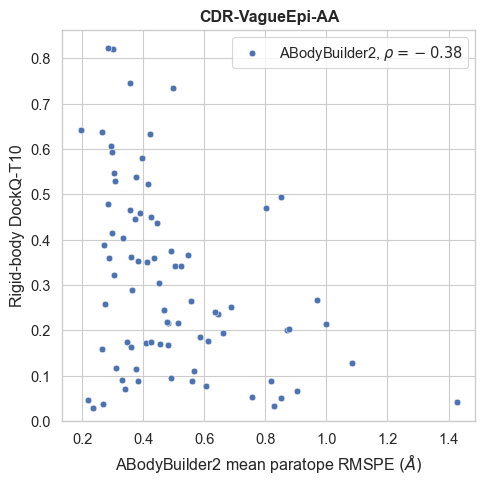

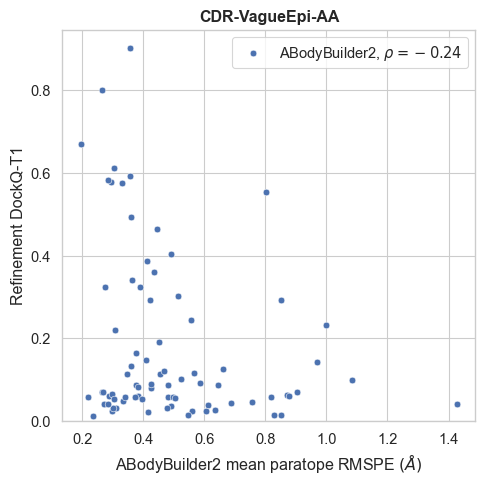

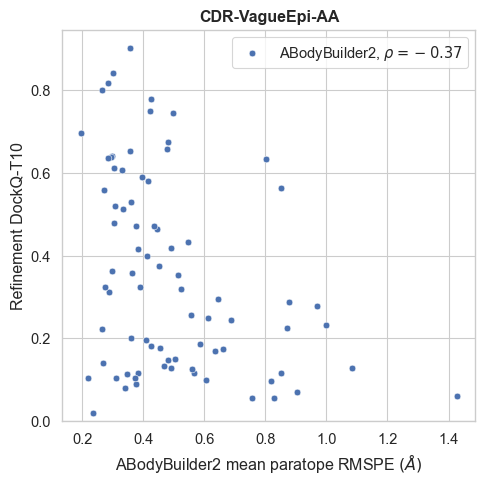

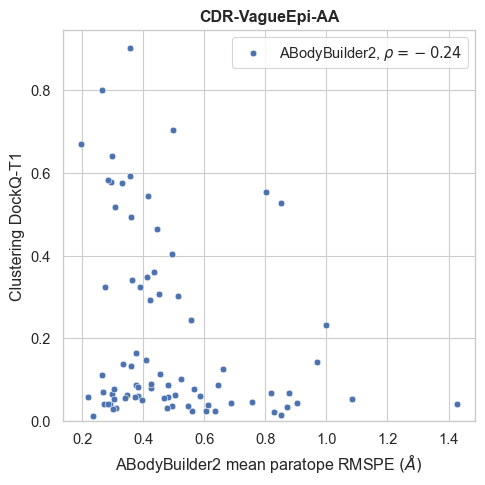

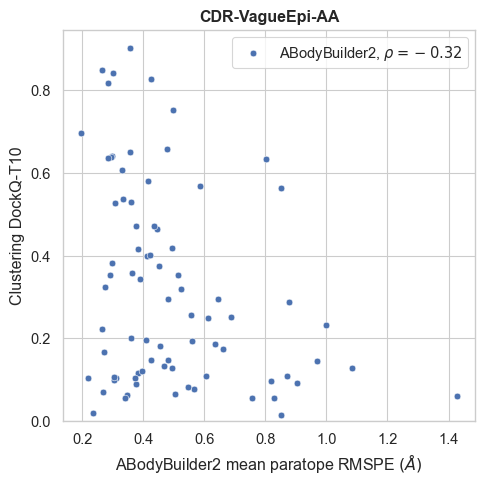

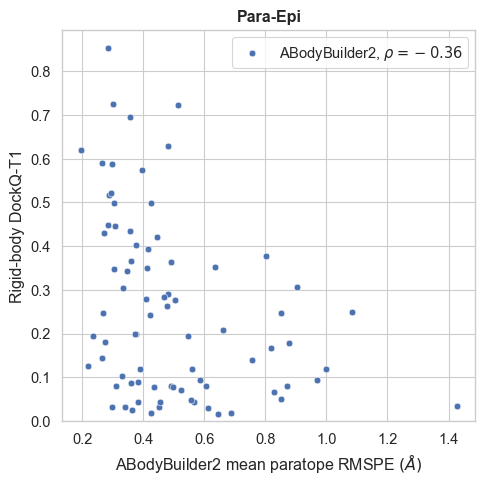

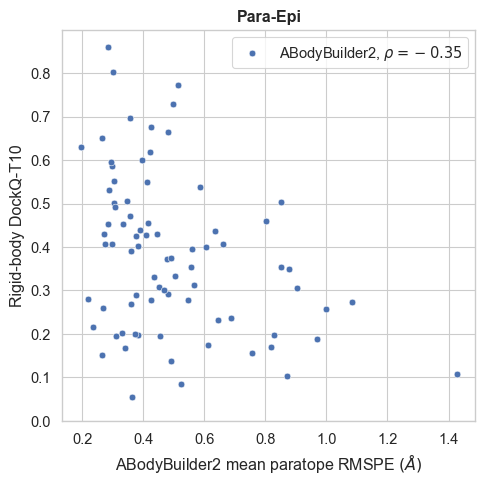

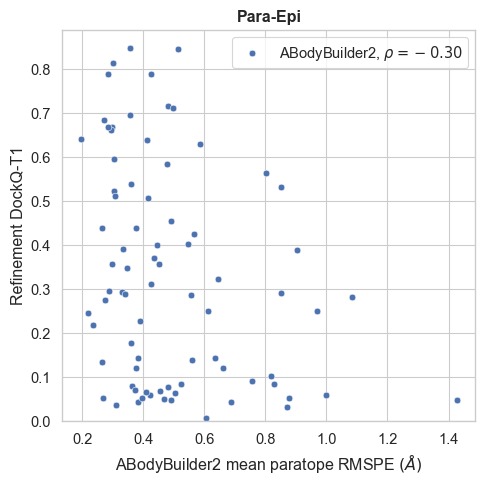

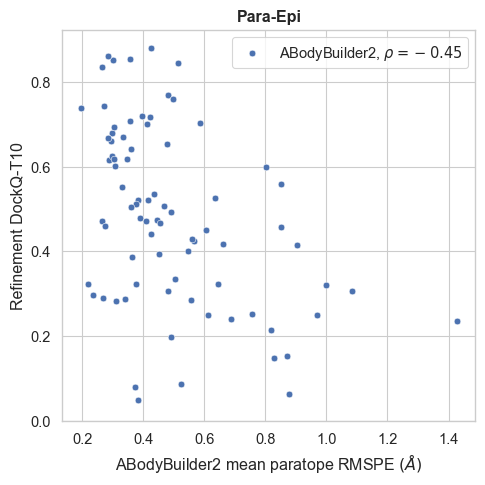

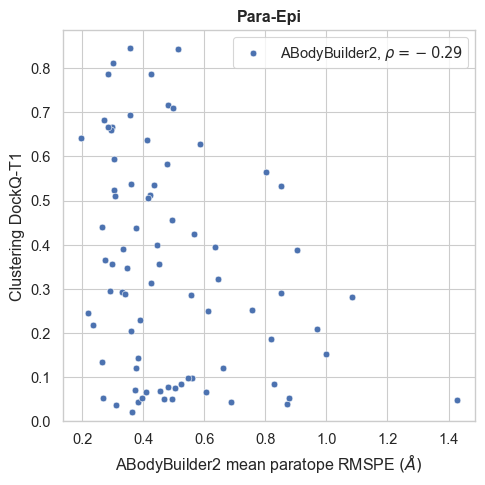

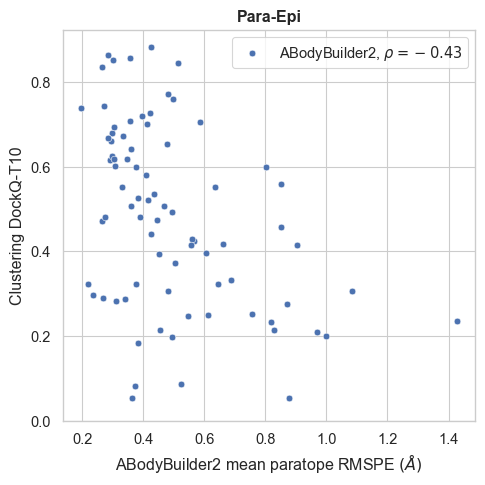

In [15]:
paratope_conf_df = pd.read_csv('../data/ABB2_antibody_rmsd_conf.csv')
paratope_conf_dict = {row.pdb : row.para_vague_ave_conf for row in paratope_conf_df.itertuples()}
model_name, model_run_str = 'ABodyBuilder2', 'ab'

plot_folder = root_plot_folder / "paratope_vague_conf_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)
for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        model_df['para_ave_conf'] = [paratope_conf_dict[pdbid] for pdbid in model_df['pdb']]
        model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=1) for pdb in model_df['pdb']]
        model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                           f'run-af2{model_run_str}-{protocol_str}'
                                           /f'{eval_folder}'/'capri_ss.tsv'
                                             , n_ranks=10) for pdb in model_df['pdb']]

        dockq1_pearson , _ = pearsonr(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['para_ave_conf'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['para_ave_conf'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['para_ave_conf'], model_df['dockq_10'])



        sns.scatterplot(x="para_ave_conf", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="para_ave_conf", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'ABodyBuilder2 mean paratope RMSPE $(\AA)$')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_conf_ABB2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'ABodyBuilder2 mean paratope RMSPE $(\AA)$')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_conf_ABB2_{protocol}_{stage}.png',dpi=200)


# Plot DockQ vs AF2 antigen pLDDT

In [16]:
epitope_plddt_df = pd.read_csv('../data/AF2_antigen_rmsd_plddt_multi_regions.csv')
epitope_plddt_dict = {row.pdb : row.plddt_ave_para_epi for row in epitope_plddt_df.itertuples()}

plot_folder = root_plot_folder / "epitope_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, (model_name, model_run_str) in enumerate(model_name_run_dict.items()):
            model_df = rmsds_df.query('model==@model_name').copy()
            model_df['epi_ave_plddt'] = [epitope_plddt_dict[pdbid] for pdbid in model_df['pdb']]

            model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=1) for pdb in model_df['pdb']]
            model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=10) for pdb in model_df['pdb']]

            dockq1_pearson , _ = pearsonr(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['epi_ave_plddt'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['epi_ave_plddt'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['epi_ave_plddt'], model_df['dockq_10'])



            sns.scatterplot(x="epi_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="epi_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean epitope pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_AF2_epitope_plddt_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean epitope pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_AF2_epitope_plddt_all_models_{protocol}_{stage}.png',dpi=200)


# Same but vague epitope definition

In [17]:
epitope_plddt_df = pd.read_csv('../data/AF2_antigen_rmsd_plddt_multi_regions.csv')
epitope_plddt_dict = {row.pdb : row.plddt_ave_vague for row in epitope_plddt_df.itertuples()}

plot_folder = root_plot_folder / "epitope_vague_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, (model_name, model_run_str) in enumerate(model_name_run_dict.items()):
            model_df = rmsds_df.query('model==@model_name').copy()
            model_df['epi_ave_plddt'] = [epitope_plddt_dict[pdbid] for pdbid in model_df['pdb']]

            model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=1) for pdb in model_df['pdb']]
            model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=10) for pdb in model_df['pdb']]

            dockq1_pearson , _ = pearsonr(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['epi_ave_plddt'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['epi_ave_plddt'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['epi_ave_plddt'], model_df['dockq_10'])



            sns.scatterplot(x="epi_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="epi_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean epitope pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_AF2_epitope_plddt_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean epitope pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_AF2_epitope_plddt_all_models_{protocol}_{stage}.png',dpi=200)


# Paratope rmsd vs dockq10 with true antigen

In [18]:
plot_folder = root_plot_folder / "paratope_rmsd_true_antigen"
plot_folder.mkdir(exist_ok=True)


for protocol, protocol_str in protocols_dict.items():
    for stage, eval_folder in stage_to_eval_dict.items():
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, (model_name, model_run_str) in enumerate(model_name_run_dict.items()):
            model_df = rmsds_df.query('model==@model_name').copy()

            model_df['dockq_1'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=1) for pdb in model_df['pdb']]
            model_df['dockq_10'] = [get_top_dockq(local_results_path/f'{pdb}'/
                                               f'run-af2{model_run_str}-{protocol_str}'
                                               /f'{eval_folder}'/'capri_ss.tsv'
                                                 , n_ranks=10) for pdb in model_df['pdb']]

            dockq1_pearson , _ = pearsonr(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['rmsd_paratope'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['rmsd_paratope'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['rmsd_paratope'], model_df['dockq_10'])



            sns.scatterplot(x="rmsd_paratope", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="rmsd_paratope", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'Paratope RMSD $\left(\AA\right)$')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')
        #ax_dockq1.set_xlim([0,5])
        ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_rmsd_true_anti_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(fr'Paratope RMSD $\left(\AA\right)$')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_rmsd_true_anti_all_models_{protocol}_{stage}.png',dpi=200)
